In [1]:
import torch
from torch import nn
from d2l import torch as d2l

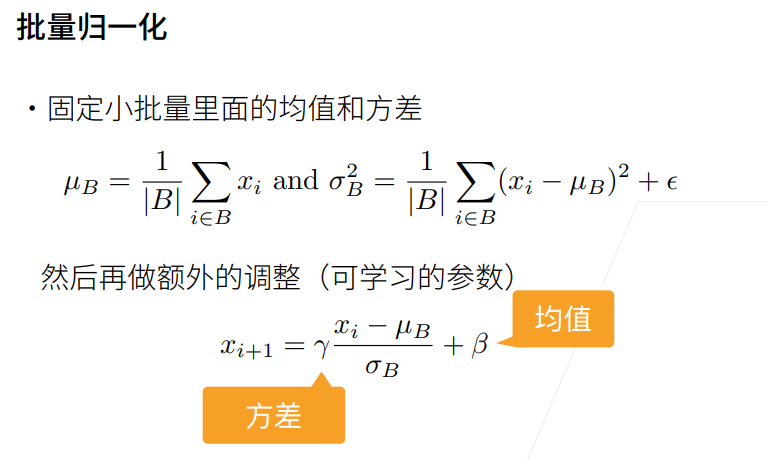
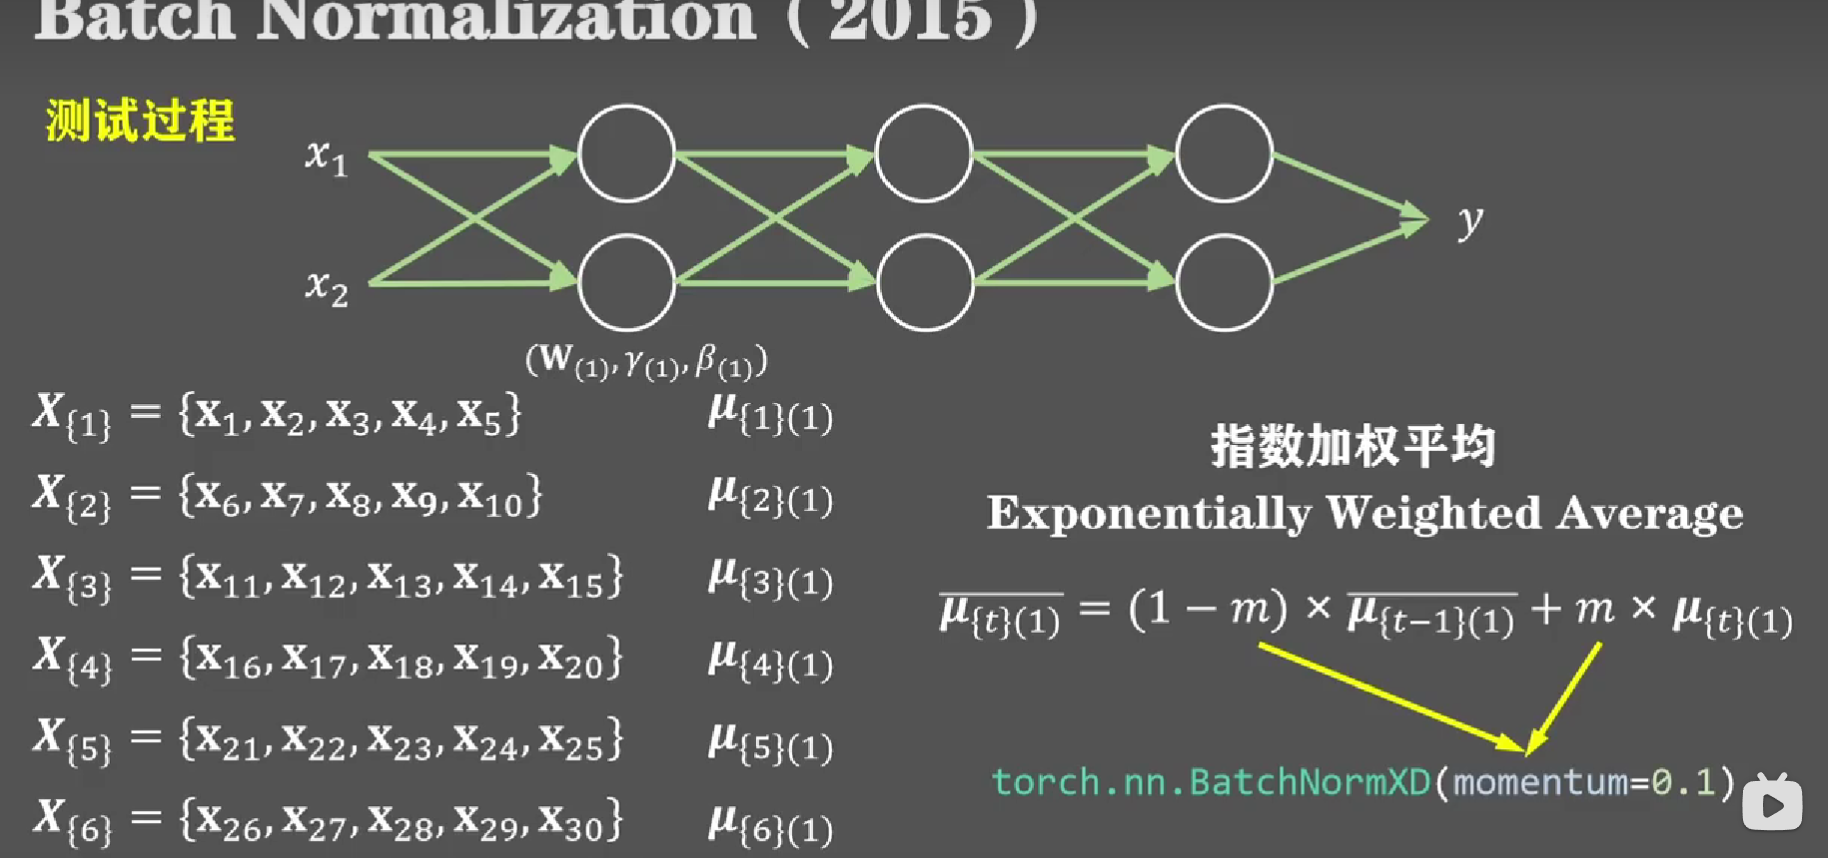  momentum历史遗留

In [2]:
def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):#gamma,beta在上图
    if not torch.is_grad_enabled():# 检查当前是否在梯度计算模式下,如果不在就是在推理过程，也就是验证过程
        X_hat = (X-moving_mean)/torch.sqrt(moving_var+eps)
    else:
        assert len(X.shape) in (2,4)#确保数据的形状为2维或4维
        if len(X.shape) == 2:
            mean = X.mean(dim=0)#对于二维的全连接层的输入形状是(batch_sizes,features)
            var = ((X-mean)**2).mean(dim=0)
        else:
            mean = X.mean(dim=(0,2,3),keepdim=True)## 2d的卷积层的输入，也就是批量归一化输入为(batch_sizes,channels,height,width),输出为1*channels*1*1
            var = (X-mean)/torch.sqrt(var+eps)
        X_hat = (X-mean)/torch.sqrt(var+eps)
        moving_mean = momentum*moving_mean + (1.0-momentum)*mean
        moving_var = momentum*moving_var +(1.0-momentum)*var
    Y = gamma * X_hat + beta
    return Y,moving_mean.data,moving_var.data

In [3]:
## 定义归一化层
class BatchNorm(nn.Module):
    def __init__(self,num_features,num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1,num_features)
        else:
            shape = (1,num_features,1,1)
        self.gamma = nn.Parameter(torch.ones(shape))##需要被迭代，所以必须是nn.Parameter类型
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)### 静态变量？？？？？？
        self.moving_var = torch.ones(shape)
    def forward(self,X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)#X是输入，如果输入是存在GPU/cpu上，就必须挪到相应的设备上去
            self.moving_mean = self.moving_var.to(X.device)
        Y,self.moving_mean,self.moving_var = batch_norm(
            X,self.gamma,self.beta,self.moving_mean,self.moving_var,eps=1e-5,momentum=0.9
        )
        return Y

In [4]:
net = nn.Sequential(nn.Conv2d(1,6,kernel_size=5),BatchNorm(6,num_dims=4),nn.Sigmoid()
                    ,nn.MaxPool2d(kernel_size=2,stride=2),nn.Conv2d(6,16,kernel_size =5),
                    BatchNorm(16,num_dims=4),nn.Sigmoid(),nn.MaxPool2d(kernel_size=2,stride=2),
                    nn.Flatten(),nn.Linear(16*4*4,120),BatchNorm(84,num_dims=2),
                    nn.Sigmoid(),nn.Linear(84,10))

training on cuda:0


UnboundLocalError: local variable 'var' referenced before assignment

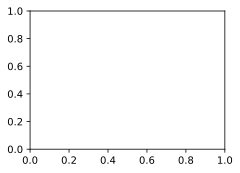

In [6]:
lr,num_epochs,batch_size =1.0,10,256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())